In [1]:
from __future__ import annotations

import datetime
import os
import os.path as osp
import textwrap
from typing import Callable, Optional, Type

import lqsvg.experiment.analysis as analysis
import lqsvg.experiment.utils as eutil
import lqsvg.torch.named as nt
import lqsvg.torch.utils as tutil
import matplotlib as mpl
import matplotlib.pyplot as plt

# Format y axis as percent: https://stackoverflow.com/a/36319915/7842251
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)
from lqsvg.experiment.estimators import DPG, MAAC, AnalyticSVG, MonteCarloSVG
from lqsvg.experiment.plot import default_figsize, plot_surface
from lqsvg.np_util import RNG
from lqsvg.policy.modules import QuadQValue, TVLinearPolicy
from torch import Tensor
from tqdm.auto import tqdm, trange

In [2]:
ray.init()

2021-07-02 11:35:00,769	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.15.8',
 'raylet_ip_address': '192.168.15.8',
 'redis_address': '192.168.15.8:6379',
 'object_store_address': '/tmp/ray/session_2021-07-02_11-35-00_279558_16508/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-07-02_11-35-00_279558_16508/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-07-02_11-35-00_279558_16508',
 'metrics_export_port': 48665,
 'node_id': '1ace4acb6cf4ebee58509815d075b77531e31f72f975c501678065fc'}

In [3]:
DEBUG = False

# Matplotlib setup

Latex presets ([ref](https://jwalton.info/Embed-Publication-Matplotlib-Latex/))

In [4]:
from functools import partial

from lqsvg.experiment.plot import STYLE_PATH, available_styles, latex_size, save_pdf_tight, create_latex_style

create_latex_style()
set_size = partial(latex_size, width="thesis")

In [5]:
print(*available_styles())

Solarize_Light2 _classic_test_patch bmh classic dark_background fast fivethirtyeight ggplot grayscale seaborn seaborn-bright seaborn-colorblind seaborn-dark seaborn-dark-palette seaborn-darkgrid seaborn-deep seaborn-muted seaborn-notebook seaborn-paper seaborn-pastel seaborn-poster seaborn-talk seaborn-ticks seaborn-white seaborn-whitegrid tableau-colorblind10 tex


In [6]:
print(f"Your style sheets are located at: {STYLE_PATH}")

Your style sheets are located at: /home/angelo/.cache/pypoetry/virtualenvs/lqsvg-3RqEHojC-py3.8/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib


In [7]:
# Using seaborn's style
plt.style.use("seaborn")
# With LaTex fonts
plt.style.use("tex")

In [8]:
def figpath(name: str) -> str:
    return osp.join("images", name + ".pdf")


def savefig(fig, name):
    return save_pdf_tight(fig, figpath(name))

In [9]:
if DEBUG:
    # Test
    x = np.linspace(0, 2 * np.pi, 100)
    # Initialise figure instance
    fig, ax = plt.subplots(1, 1, figsize=set_size())

    # Plot
    ax.plot(x, np.sin(x))
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\sin (\theta)$")

    savefig(fig, "example")

In [10]:
if osp.exists(figpath("example")):
    os.remove(figpath("example"))

# Experimental setup

## Biased/Unbiased (DPG/MAAC) estimators

In [11]:
class KStepModules(nn.Module):
    def __init__(
        self,
        policy: TVLinearPolicy,
        transition: LinearDynamicsModule,
        reward: QuadraticReward,
        qvalue: QuaQValue,
    ):
        super().__init__()
        self.policy = policy
        self.transition = transition
        self.reward = reward
        self.qvalue = qvalue


class KStepEstimator(nn.Module):
    def __init__(
        self, modules: KStepModules, obs: Tensor, kind: Union[Type[DPG], Type[MAAC]]
    ):
        super().__init__()
        self.nn = modules
        self.state_dataset = obs
        self.kind = kind
        self.estimator = self.kind(
            modules.policy, modules.transition, modules.reward, modules.qvalue
        )
        self.n_steps: int = 0

    def sample_starting_obs(self, samples: int) -> Tensor:
        if samples == self.state_dataset.size("B"):
            return self.state_dataset
        idxs = torch.randint(low=0, high=self.state_dataset.size("B"), size=(samples,))
        return nt.index_select(self.state_dataset, dim="B", index=idxs)

    def surrogate(self, samples: int = 1) -> Tensor:
        obs = self.sample_starting_obs(samples)
        return self.estimator.surrogate(obs, n_steps=self.n_steps)

    def forward(self, samples: int = 1) -> tuple[Tensor, lqr.Linear]:
        obs = self.sample_starting_obs(samples)
        return self.estimator(obs, n_steps=self.n_steps)

    def delta_to_surrogate(
        self, samples: int, n_step: int, update_q: bool = False
    ) -> Callable[[np.ndarray], np.ndarray]:
        K_0, k_0 = self.nn.policy.standard_form()

        @torch.no_grad()
        def f_delta(delta: np.ndarray) -> np.ndarray:
            vector = nt.vector(tutil.as_float_tensor(delta))
            delta_K, delta_k = tutil.vector_to_tensors(vector, (K_0, k_0))
            policy = TVLinearPolicy.from_existing((K_0 + delta_K, k_0 + delta_k))
            if update_q:
                qvalue = QuadQValue.from_policy(
                    policy.standard_form(),
                    self.nn.transition.standard_form(),
                    self.nn.reward.standard_form(),
                )
            else:
                qvalue = self.nn.qvalue
            modules = KStepModules(policy, self.nn.transition, self.nn.reward, qvalue)
            estimator = KStepEstimator(modules, self.state_dataset, self.kind)
            estimator.n_steps = n_step
            surrogate = estimator.surrogate(samples)
            return surrogate.numpy()

        return f_delta

## Environment and policy generation

LQG parameters: 
1. $|S| = 2, |A| = 2, |H| = 20$
2. Stationary dynamics and cost
3. Passive dynamics eigvals $|\lambda_i| \sim \mathcal{U}(0.5, 1.5)$
4. Controllable
5. Transition covariance $\Sigma = I$
6. Cost $s^\intercal C_{ss} s + a^\intercal C_{aa} a$

In [12]:
def make_generator(seed: int) -> LQGGenerator:
    return LQGGenerator(
        n_state=2,
        n_ctrl=2,
        horizon=20,
        stationary=True,
        passive_eigval_range=(0.5, 1.5),
        controllable=True,
        rng=seed,
    )

In [13]:
def grad_estimates(
    estimator,
    sample_sizes: list[int],
    estimates_per_sample_size: int = 10,
    pbar: bool = False,
) -> list[list[lqr.Linear]]:
    """Helper to sample several SVG estimates for different sample sizes."""
    progress = tqdm(
        sample_sizes, desc="Computing SVG by sample size", leave=False, disable=not pbar
    )
    svgs_by_sample_size = []
    for size in progress:
        svgs = [estimator(samples=size)[1] for _ in range(estimates_per_sample_size)]
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

In [14]:
class Trial:
    def __init__(self, seed: int, total_states: int = 1000):
        self.rng = np.random.default_rng(seed)
        self.generator = make_generator(self.rng)
        self.lqg, self.policy, self.qvalue = self.make_modules(self.generator)

        with tutil.default_generator_seed(seed):
            self.states = self.starting_states(self.policy, self.lqg, total_states)

        modules = KStepModules(
            self.policy, self.lqg.trans, self.lqg.reward, self.qvalue
        )
        self.estimator = {
            "dpg": KStepEstimator(modules, self.states, kind=DPG),
            "maac": KStepEstimator(modules, self.states, kind=MAAC),
        }

    def make_modules(
        self, generator: LQGGenerator
    ) -> tuple[LQGModule, TVLinearPolicy, QuadQValue]:
        with nt.suppress_named_tensor_warning():
            dynamics, cost, init = generator()
        model = LQGModule.from_existing(dynamics, cost, init)
        policy = TVLinearPolicy(model.n_state, model.n_ctrl, model.horizon)
        policy.stabilize_(dynamics, rng=self.rng)
        qvalue = QuadQValue.from_policy(policy.standard_form(), dynamics, cost)
        return model, policy, qvalue

    @staticmethod
    def starting_states(policy: TVLinearPolicy, model: LQGModule, num: int) -> Tensor:
        rollout_module = MonteCarloSVG(policy, model)
        n_trajs = num // model.horizon
        with torch.no_grad():
            obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([n_trajs]))
        obs = obs.flatten(["H", "B1"], "B")
        return obs

# Experiments

## Gradient estimation for fixed policies

In [15]:
@ray.remote
class GradientQualityTrial(Trial):
    """Helper to collect gradient quality metrics for a specific environment-policy pair.

    Environment-policy pair determined by seed.
    """

    def __init__(self, seed: int, total_states: int):
        super().__init__(seed, total_states)
        _, self.true_svg = AnalyticSVG(self.policy, self.lqg)()

    def gradient_quality_vs_samples(
        self, sample_sizes: np.ndarray, n_step: int, estimates: int
    ) -> pd.DataFrame:
        rows = sum(
            (self.gradient_estimation_data(s, n_step, estimates) for s in sample_sizes),
            start=[],
        )
        columns = [
            "#Samples",
            "Avg. cos sim with true grad",
            "Avg. pairwise cos sim",
            "Norm",
            "Estimator",
        ]
        data = pd.DataFrame(rows, columns=columns)
        data["K"] = n_step
        data["trial"] = self.generator.rng
        return data

    def gradient_estimation_data(
        self, samples: int, n_step: int, estimates: int
    ) -> list:
        rows = []
        for name, estimator in self.estimator.items():
            svgs = self.grad_estimates(estimator, samples, n_step, estimates)
            cossim = analysis.gradient_accuracy(svgs, self.true_svg)
            empvar = analysis.empirical_variance(svgs)
            norm = np.mean([eutil.linear_feedback_norm(s).numpy() for s in svgs])
            rows += [[samples, cossim, empvar, norm, name]]

        return rows

    @staticmethod
    def grad_estimates(
        estimator, samples: int, n_step: int, estimates: int = 10
    ) -> list[lqr.Linear]:
        old = estimator.n_steps
        estimator.n_steps = n_step
        estimates = [estimator(samples)[1] for _ in range(estimates)]
        estimator.n_steps = old
        return estimates

In [16]:
class GradientQualityComparison:
    """Helper to collect gradient quality metrics over several environment-policy pairs.

    Uses Ray to distribute computation via trial Actors.
    """

    def __init__(self, seeds: list[int], total_states: int = 1000):
        self.seeds = seeds
        self.total_states = total_states
        self.actors = None
        self.data = None

    def collect(self, sample_sizes: np.ndarray, n_steps: np.ndarray):
        if self.actors is None:
            self.actors = [
                GradientQualityTrial.remote(seed=s, total_states=self.total_states)
                for s in self.seeds
            ]

        remaining = [
            a.gradient_quality_vs_samples.remote(sample_sizes, n_step=k, estimates=10)
            for k in n_steps
            for a in self.actors
        ]
        ready = []
        with tqdm(desc="Collecting", total=len(remaining)) as pbar:
            while remaining:
                done, remaining = ray.wait(remaining)
                ready += done
                pbar.update(len(done))
        self.data = pd.concat(ray.get(ready), ignore_index=True)

    def save(self, name: str = ""):
        assert self.data is not None
        now = datetime.datetime.now().isoformat(timespec="minutes")
        fname = f"{type(self).__name__}-{now}.csv"
        prfx = name + "-" if name else ""
        path = osp.join("local", prfx + fname)
        self.data.to_csv(path, index=False)

    def load(self, path: str):
        assert self.data is None
        self.data = pd.read_csv(path, index_col=False)

### Bias/variance vs. sample size vs. K steps

In [17]:
# comp = GradientQualityComparison(seeds=np.arange(10), total_states=1000)
# comp.collect(
#     sample_sizes=np.linspace(1, comp.total_states, 200, dtype=int), n_steps=[2]
# )
# comp.save("BiasVarianceNorm-K=2")

In [18]:
def fgrid_size(rows: int, cols: int, **setsize_kws) -> dict:
    """Kwargs to set FacetGrid size based on number of rows and cols."""
    w, h = set_size(subplots=(rows, cols), **setsize_kws)
    return dict(height=h / rows, aspect=(w / cols) / (h / rows))


def plot_gradient_acc(data):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Avg. cos sim with true grad",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci=95,
        facet_kws=dict(legend_out=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Accuracy")
    fgrid.tight_layout()
    return fgrid


def plot_gradient_prc(data):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Avg. pairwise cos sim",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci=95,
        facet_kws=dict(legend_out=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Precision")
    fgrid.tight_layout()
    return fgrid

In [19]:
BIAS_VAR_NORM_DATA = pd.concat(
    (
        pd.read_csv(
            "local/BiasVarianceNorm-K=0,4,8-GradientQualityComparison-2021-05-28T12:04.csv",
            index_col=False,
        ),
        pd.read_csv(
            "local/BiasVarianceNorm-K=2-GradientQualityComparison-2021-05-31T11:04.csv",
            index_col=False,
        ),
    ),
    ignore_index=True,
)

In [20]:
BIAS_VAR_NORM_DATA["#Samples"].value_counts().sort_index()

1       80
6       80
11      80
16      80
21      80
        ..
979     80
984     80
989     80
994     80
1000    80
Name: #Samples, Length: 200, dtype: int64

rows: 2, cols: 2


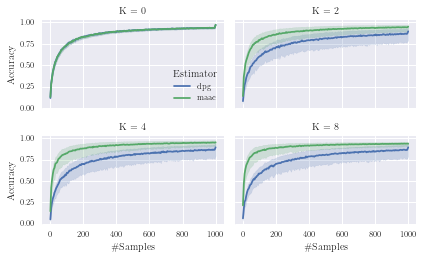

In [21]:
savefig(plot_gradient_acc(BIAS_VAR_NORM_DATA), "GradientAcc")

rows: 2, cols: 2


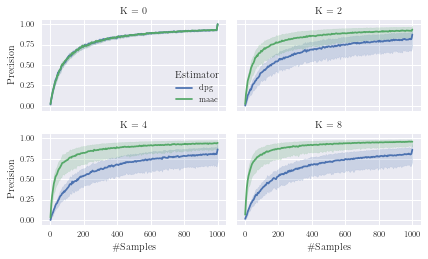

In [22]:
savefig(plot_gradient_prc(BIAS_VAR_NORM_DATA), "GradientPrc")

### Gradient signal strength

In [23]:
def plot_gradient_norm(data, agg: bool = True):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Norm",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci="sd",
        facet_kws=dict(legend_out=False, sharey=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    for nstep, ax in fgrid.axes_dict.items():
        ax.set_ylim(np.percentile(data[data["K"] == nstep]["Norm"], [2.5, 97.5]))
    #     fgrid.set(ylim=np.percentile(data["Norm"], [2.5, 97.5]))
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Gradient norm")
    fgrid.tight_layout()
    return fgrid

rows: 2, cols: 2


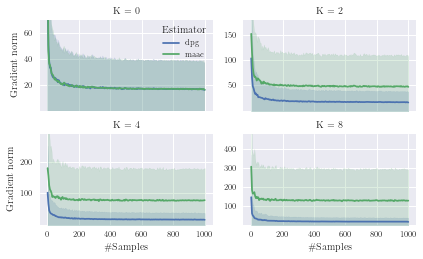

In [24]:
savefig(plot_gradient_norm(BIAS_VAR_NORM_DATA, agg=False), "GradientNorm")

### Estimator bias at convergence

In [25]:
# comp = GradientQualityComparison(seeds=np.arange(10), total_states=50000)
# comp.collect([comp.total_states], np.arange(1, 21))
# comp.save("Convergence")

In [26]:
CONVERGENCE_DATA = pd.read_csv(
    "local/Convergence-GradientQualityComparison-2021-05-25T15.20.csv", index_col=False
)

In [27]:
CONVERGENCE_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   #Samples                     400 non-null    int64  
 1   Avg. cos sim with true grad  400 non-null    float64
 2   Avg. pairwise cos sim        400 non-null    float64
 3   Norm                         400 non-null    float64
 4   Estimator                    400 non-null    object 
 5   K                            400 non-null    int64  
 6   trial                        400 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 22.0+ KB


In [28]:
def plot_acc_vs_nstep(data):
    data = data[data["#Samples"] == data["#Samples"].max()]
    fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.7))
    sns.scatterplot(
        ax=ax,
        data=data,
        x="K",
        y="Avg. cos sim with true grad",
        hue="Estimator",
        style="Estimator",
        s=10,  # Marker size https://stackoverflow.com/a/52785672/7842251
        alpha=0.75,
    )
    ax.set_xlabel("$K$")
    ax.set_ylabel("Accuracy")
    ax.set_xticks(data["K"].unique()[::2])
    ax.legend(markerscale=0.75)
    return savefig(fig, "convergence")

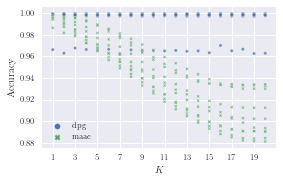

In [29]:
plot_acc_vs_nstep(CONVERGENCE_DATA)

## Impact of gradient quality on policy optimization

In [30]:
from typing import Iterable, TypeVar

from raylab.utils.exp_data import load_exps_data

T = TypeVar("T")

In [31]:
def dict_exclude(mapping: dict[str, T], keys: Iterable[str]) -> dict[str, T]:
    return {k: mapping[k] for k in set(mapping.keys()).difference(set(keys))}


def push_config_to_dataframe(exp_data):
    progress = exp_data.progress
    params = dict_exclude(exp_data.params, ["wandb_tags", "wandb_dir"])
    return pd.concat((progress, pd.DataFrame(params, index=progress.index)), axis=1)


def read_optimization_data(path: str) -> pd.DataFrame:
    exps_data = load_exps_data(path)
    dfs = [push_config_to_dataframe(e) for e in exps_data]
    return pd.concat(dfs, ignore_index=True)

In [32]:
OPTIMIZATION_DATA = read_optimization_data("results/Experiment_2021-06-07_09-25-12/")
OPTIMIZATION_DATA.head()

,true_value,optimal_value,episode_reward_mean,episode_reward_max,episode_reward_min,done,timesteps_total,episodes_total,training_iteration,experiment_id,...,trial_id,B,K,id,policy_seed,estimator,env_seed,exp_name,learning_rate,normalize_svg
0,-483.535492,66.275909,-579.011043,0.0,-1029.002441,False,NaN,NaN,1,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,200,8,67d8a_00084,2,dpg,4,Experiment_2021-06-07_09-25-12,0.01,True
1,-480.538269,66.275909,-511.882672,0.0,-1029.002441,False,NaN,NaN,2,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,200,8,67d8a_00084,2,dpg,4,Experiment_2021-06-07_09-25-12,0.01,True
2,-477.757080,66.275909,-451.761725,0.0,-1029.002441,False,NaN,NaN,3,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,200,8,67d8a_00084,2,dpg,4,Experiment_2021-06-07_09-25-12,0.01,True
3,-474.939087,66.275909,-447.503235,0.0,-1029.002441,False,NaN,NaN,4,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,200,8,67d8a_00084,2,dpg,4,Experiment_2021-06-07_09-25-12,0.01,True
4,-471.864990,66.275909,-480.956620,0.0,-2136.937988,False,NaN,NaN,5,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,200,8,67d8a_00084,2,dpg,4,Experiment_2021-06-07_09-25-12,0.01,True


In [33]:
OPTIMIZATION_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387000 entries, 0 to 386999
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   true_value                387000 non-null  float64
 1   optimal_value             387000 non-null  float64
 2   episode_reward_mean       387000 non-null  float64
 3   episode_reward_max        387000 non-null  float64
 4   episode_reward_min        387000 non-null  float64
 5   done                      387000 non-null  bool   
 6   timesteps_total           0 non-null       float64
 7   episodes_total            0 non-null       float64
 8   training_iteration        387000 non-null  int64  
 9   experiment_id             387000 non-null  object 
 10  date                      387000 non-null  object 
 11  timestamp                 387000 non-null  int64  
 12  time_this_iter_s          387000 non-null  float64
 13  time_total_s              387000 non-null  f

In [34]:
HUE_ORDER = "dpg maac".split()

In [35]:
def learning_curves(data, ci="sd"):
    data = data.copy()
    data["Iteration"] = data["training_iteration"]
    data["Cost"] = -data["true_value"]
    data["seed"] = data["env_seed"]

    cols = 2
    rows = (len(data["seed"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")
    w, h = set_size(fraction=1, subplots=(rows, cols))
    print(f"width: {w}, height: {h}")

    fgrid = sns.relplot(
        data=data,
        kind="line",
        x="Iteration",
        y="Cost",
        hue="estimator",
        hue_order=HUE_ORDER,
        ci=ci,
        col="seed",
        col_wrap=cols,
        height=h / rows,
        aspect=(w / cols) / (h / rows),
        facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    )
    for ax in fgrid.axes:
        ax.set_title(None)
    for seed, ax in fgrid.axes_dict.items():
        ax.set_ylim(top=np.percentile(data[data["seed"] == seed]["Cost"], 97.5))
    fgrid.tight_layout()
    return fgrid

### Unnormalized gradients

rows: 4, cols: 2
width: 5.98425197177252, height: 7.396942231597988


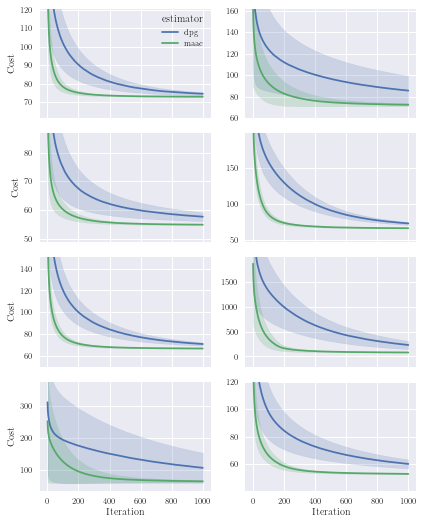

In [36]:
savefig(
    learning_curves(
        OPTIMIZATION_DATA.query("normalize_svg == False & env_seed not in [2, 7]")
    ),
    "unnormalized_svg_optimization",
)

rows: 2, cols: 2
width: 5.98425197177252, height: 3.698471115798994


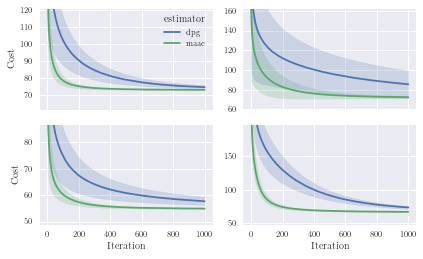

In [37]:
savefig(
    learning_curves(
        OPTIMIZATION_DATA.query(
            "normalize_svg == False & env_seed not in [2, 7, 5, 6, 8, 9]"
        )
    ),
    "unnormalized_svg_optimization_short",
)

### Normalized gradients

rows: 4, cols: 2
width: 5.98425197177252, height: 7.396942231597988


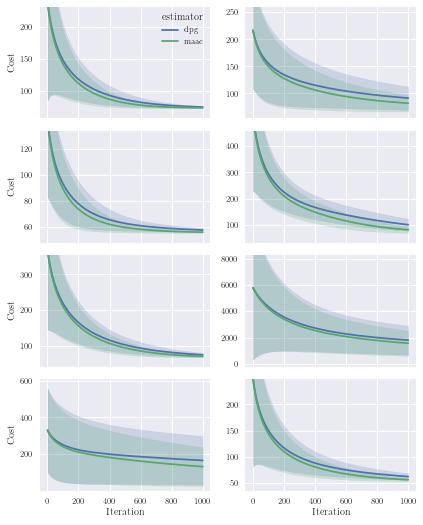

In [38]:
savefig(
    learning_curves(
        OPTIMIZATION_DATA.query("normalize_svg == True & env_seed not in [2, 7]")
    ),
    "normalized_svg_optimization",
)

rows: 2, cols: 2
width: 5.98425197177252, height: 3.698471115798994


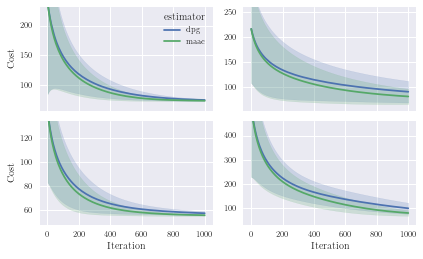

In [39]:
savefig(
    learning_curves(
        OPTIMIZATION_DATA.query(
            "normalize_svg == True & env_seed not in [2, 7, 5, 6, 8, 9]"
        )
    ),
    "normalized_svg_optimization_short",
)

## Suboptimality Gap

### SGD (clip gradient norm)

In [40]:
def read_suboptimality_data(logdir: str) -> pd.DataFrame:
    data = read_optimization_data(logdir)
    data["Iteration"] = data["training_iteration"]
    data["Cost"] = -data["true_value"]
    data["Optimal"] = -data["optimal_value"]
    data["Suboptimality"] = 100 * (data["Cost"] - data["Optimal"]) / data["Optimal"]
    data["Grad Norm"] = data["grad_norm"]
    data["Dim"] = data["env_dim"]
    return data

In [41]:
OLD_SGD_DATA = read_suboptimality_data("results/SuboptimalityGap_2021-06-11_16-51-21/")
OLD_SGD_DATA.head()

,true_value,optimal_value,episode_reward_mean,episode_reward_max,episode_reward_min,grad_norm,done,timesteps_total,episodes_total,training_iteration,...,estimator,optimizer,exp_name,learning_rate,Iteration,Cost,Optimal,Suboptimality,Grad Norm,Dim
0,-5018.206543,-345.370789,-5873.838309,0.000000,-11141.529297,158.351074,False,NaN,NaN,1,...,dpg,SGD,SuboptimalityGap_2021-06-11_16-51-21,0.009999,1,5018.206543,345.370789,1352.991020,158.351074,6
1,-4665.534180,-345.370789,-5085.812488,0.000000,-11141.529297,88.504059,False,NaN,NaN,2,...,dpg,SGD,SuboptimalityGap_2021-06-11_16-51-21,0.009999,2,4665.534180,345.370789,1250.876893,88.504059,6
2,-4474.504883,-345.370789,-4825.670702,0.000000,-11141.529297,76.582443,False,NaN,NaN,3,...,dpg,SGD,SuboptimalityGap_2021-06-11_16-51-21,0.009999,3,4474.504883,345.370789,1195.565529,76.582443,6
3,-4347.397461,-345.370789,-4677.368520,0.000000,-11141.529297,63.513725,False,NaN,NaN,4,...,dpg,SGD,SuboptimalityGap_2021-06-11_16-51-21,0.009999,4,4347.397461,345.370789,1158.762352,63.513725,6
4,-4308.323730,-345.370789,-4640.023994,-1995.876465,-11141.529297,65.912880,False,NaN,NaN,5,...,dpg,SGD,SuboptimalityGap_2021-06-11_16-51-21,0.009999,5,4308.323730,345.370789,1147.448792,65.912880,6


In [42]:
OLD_SGD_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   true_value                180000 non-null  float64
 1   optimal_value             180000 non-null  float64
 2   episode_reward_mean       180000 non-null  float64
 3   episode_reward_max        180000 non-null  float64
 4   episode_reward_min        180000 non-null  float64
 5   grad_norm                 180000 non-null  float64
 6   done                      180000 non-null  bool   
 7   timesteps_total           0 non-null       float64
 8   episodes_total            0 non-null       float64
 9   training_iteration        180000 non-null  int64  
 10  experiment_id             180000 non-null  object 
 11  date                      180000 non-null  object 
 12  timestamp                 180000 non-null  int64  
 13  time_this_iter_s          180000 non-null  f

In [43]:
NEW_SGD_DATA = read_suboptimality_data("results/SuboptimalityGap_2021-06-12_15-59-42/")

In [44]:
NEW_SGD_DATA.query("time_total_s >= 300 & Dim == 10").groupby("estimator").mean()[
    "time_total_s"
]

estimator
dpg     300.057645
maac    300.054433
Name: time_total_s, dtype: float64

In [45]:
# def progress_summary(data: pd.DataFrame) -> pd.DataFrame:
#     data = data.query("env_dim == 10 & estimator == 'dpg'").set_index("seed")
#     initial = data.query("Iteration == 1")[["Cost", "Optimal", "Suboptimality"]].rename(
#         columns={"Cost": "Initial cost", "Suboptimality": "Initial suboptimality"}
#     )
#     final = data.query("Iteration == 1000")[["Cost", "Suboptimality"]].rename(
#         columns={"Cost": "Final cost", "Suboptimality": "Final suboptimality"}
#     )
#     joined = pd.concat((initial, final), axis=1, join="inner").sort_index()
#     return joined[
#         [
#             "Initial cost",
#             "Final cost",
#             "Optimal",
#             "Initial suboptimality",
#             "Final suboptimality",
#         ]
#     ]
def progress_summary(data: pd.DataFrame) -> pd.DataFrame:
    data["Time (min)"] = (data["time_total_s"] // 60).astype(int)
    data = data.query("`Time (min)` in [1, 3, 5]")
    data = pd.pivot_table(
        data,
        values="Suboptimality",
        index=["estimator", "Time (min)"],
        columns="Dim",
        aggfunc=np.median,
    )
    return data.round(decimals=2)

In [46]:
progress_summary(OLD_SGD_DATA)

Dim                      2       3       4        5       6          7   \
estimator Time (min)                                                      
dpg       1           33.78  271.76  245.50  1084.98  660.50   24926.60   
          3            9.79   64.03  156.10   464.10  375.22    1673.37   
          5             NaN     NaN     NaN      NaN     NaN        NaN   
maac      1            2.94   26.44   56.34   411.35  991.87  749107.07   
          3            0.42    6.02   13.72   113.54   89.28  220849.67   

Dim                         8           9           10  
estimator Time (min)                                    
dpg       1             788.68  2728094.05  5573629.54  
          3             459.09   683900.46  3441598.69  
          5             155.29       33.70         NaN  
maac      1           40432.34   998707.48   686300.14  
          3              67.44   171805.29   154322.71

In [47]:
progress_summary(NEW_SGD_DATA)  # .to_html()

Dim                      2       3       4        5        6        7   \
estimator Time (min)                                                     
dpg       1           29.10  218.75  242.94  1730.07  1567.81  4129.88   
          3            6.32   53.21  138.89   439.54   465.29  3468.03   
          5            2.66   27.63   91.20   400.31   241.32  2877.18   
maac      1            2.33   20.31   45.05   302.72   255.53  2065.97   
          3            0.55    3.57   11.28    80.26    38.87   317.76   
          5            0.38    1.92    6.34    40.13    21.23   290.91   

Dim                        8        9        10  
estimator Time (min)                             
dpg       1           1100.74  6111.44  7290.04  
          3            552.87   277.38  6445.64  
          5            263.54  2297.37  4830.16  
maac      1            340.63  3477.36  5008.28  
          3             45.87  1468.44  3568.37  
          5             23.23   330.21  2004.51

In [48]:
print(progress_summary(NEW_SGD_DATA).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Dim</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>10</th>
    </tr>
    <tr>
      <th>estimator</th>
      <th>Time (min)</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top">dpg</th>
      <th>1</th>
      <td>29.10</td>
      <td>218.75</td>
      <td>242.94</td>
      <td>1730.07</td>
      <td>1567.81</td>
      <td>4129.88</td>
      <td>1100.74</td>
      <td>6111.44</td>
      <td>7290.04</td>
    </tr>
    <tr>
      <th>3</th>
      <td>6.32</td>
      <td>53.21</td>
      <td>138.89</td>
      <td>439.54</td>
      <td>465.29</td>
      <td>3468.03</td>
      <td>552.87</td>
      <td>277.38</td>


In [49]:
def suboptimality_curves(data, y="Suboptimality", ci="sd"):
    fgrid = sns.relplot(
        data=data,
        kind="line",
        x="time_total_s",
        y=y,
        hue="estimator",
        hue_order=HUE_ORDER,
        ci=ci,
        col="seed",
        row="Dim",
        facet_kws={"sharey": False, "legend_out": False, "margin_titles": True},
    )
    for ax in fgrid.axes.flatten():
        ax.yaxis.set_major_formatter(
            mtick.PercentFormatter(xmax=1.0, decimals=1, symbol="\%", is_latex=True)
        )
    fgrid.set_xlabels("Wall clock time (sec)")
    fgrid.tight_layout()
    return fgrid

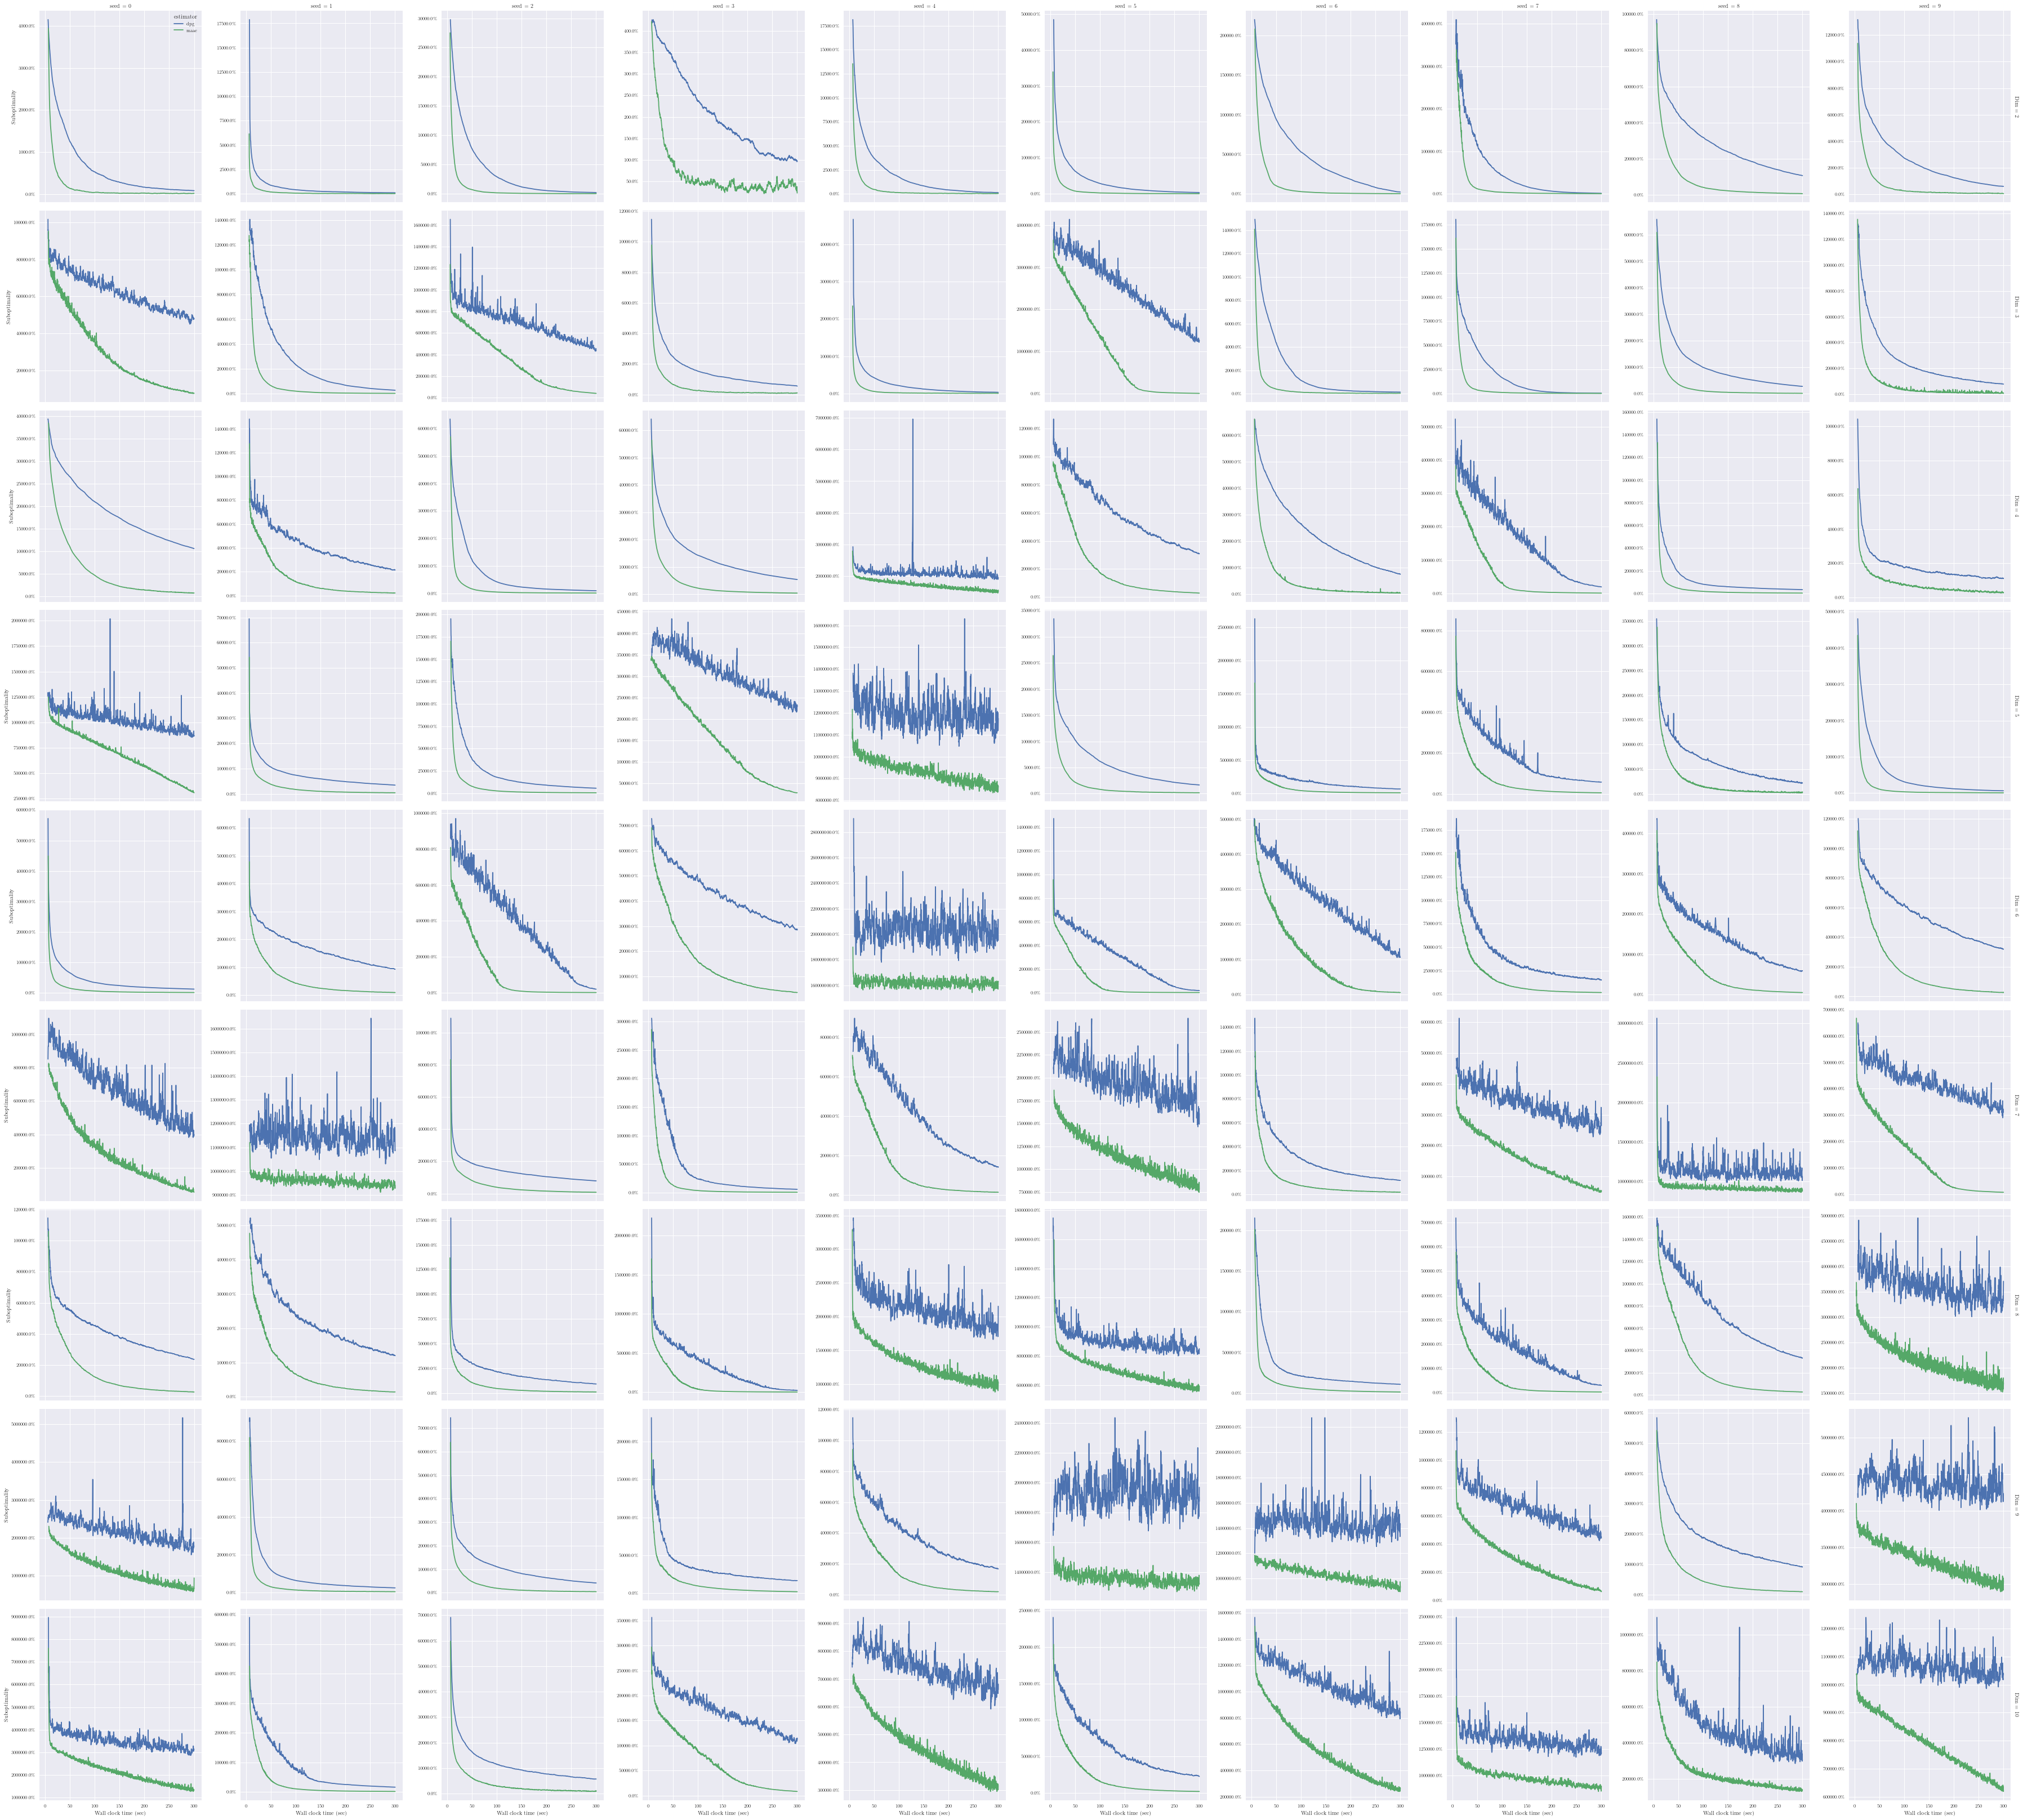

In [50]:
savefig(suboptimality_curves(NEW_SGD_DATA), "SuboptimalitySGD_clipped")

In [51]:
NEW_SGD_DATA[["K", "B", "optimizer", "learning_rate", "clip_grad_norm"]].head()

,K,B,optimizer,learning_rate,clip_grad_norm
0,8,20,SGD,0.009919,100
1,8,20,SGD,0.009919,100
2,8,20,SGD,0.009919,100
3,8,20,SGD,0.009919,100
4,8,20,SGD,0.009919,100


## Optimization surface

In [52]:
assert False  # Avoid running experiments below

AssertionError: 

In [ ]:
class OptimizationSurfaceComparison(Trial):
    def plot_real_vs_surrogate(
        self, estimator: str, samples: int, n_step: int, seed: Optional[int] = None
    ):
        sns.reset_orig()
        estim = self.estimator[estimator]
        estim.n_steps = n_step

        seed = seed or self.rng.integers(np.iinfo(int).max)
        with tutil.default_generator_seed(seed):
            _, svg = estim(samples)
            direction = tutil.tensors_to_vector(svg).numpy()

            real_XYZ = analysis.optimization_surface(
                self.delta_to_return(),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )
            surrogate_XYZ = analysis.optimization_surface(
                estim.delta_to_surrogate(samples, n_step, update_q=False),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )

        fig = plt.figure(figsize=default_figsize(2, 4))
        ax1 = fig.add_subplot(1, 2, 1, projection="3d")
        ax2 = fig.add_subplot(1, 2, 2, projection="3d")
        plot_surface(*real_XYZ, ax=ax1, invert_xaxis=True)
        plot_surface(*surrogate_XYZ, ax=ax2, invert_xaxis=True)
        ax1.set_xlabel("Random direction")
        ax2.set_xlabel("Random direction")
        ax1.set_ylabel(f"SVG ({estimator}) direction")
        ax2.set_ylabel(f"SVG ({estimator}) direction")
        ax1.set_zlabel("Policy return")
        ax2.set_zlabel("Surrogate value")
        fig.suptitle(f"NStep: {n_step}")
        plt.show()

    def delta_to_return(self) -> Callable[[np.ndarray], np.ndarray]:
        policy = self.policy.standard_form()
        dynamics, cost, init = self.lqg.standard_form()
        return analysis.delta_to_return(policy, dynamics, cost, init)

In [ ]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=10, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=10, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=20, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=20, seed=4)

In [ ]:
# comparator = OptimizationSurfaceComparison(4)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, update_q=True)

In [ ]:
comparator = OptimizationSurfaceComparison(42)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=42)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=500, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=500, n_step=4, seed=42)